# OCR Project for Debit Cards and National ID Cards

## Importing Libraries

In [1]:
# %pip install requirements.txt

In [2]:
import tensorflow as tf 
from tensorflow.keras import utils

from sklearn.model_selection import train_test_split

import os

In [3]:
utils.set_random_seed(42)

## Constants

In [4]:
from ocr.constants import (template_path, trainset_path, num_generating_en, num_generating_ID, 
                        training_phase_2, batch_size, num_anchors, model_plot_path)

## Generating Synthesized Dataset

In [5]:
from ocr.data_synthesis import generate_multiple_images


templates_type0 = os.listdir(template_path+"/credit")
templates_type1 = os.listdir(template_path+"/national ID")

num_generating_en_each_temp = num_generating_en // len(templates_type0)

templates_type0, templates_type1

(['ayandeh_1.jpg',
  'ayandeh_2.jpg',
  'dey_1.jpg',
  'dey_2.jpg',
  'ghavamin_1.jpg',
  'keshavarzi_1.jpg',
  'keshavarzi_2.jpg',
  'keshavarzi_3.jpg',
  'keshavarzi_4.jpg',
  'keshavarzi_5.jpg',
  'meli_1.jpg',
  'meli_2.jpg',
  'meli_3.jpg',
  'refah_1.jpg',
  'saderat_1.jpg',
  'saderat_2.jpg',
  'saderat_3.jpg',
  'saderat_4.jpg',
  'saderat_5.jpg',
  'saman_1.jpg',
  'sepah_1.jpg',
  'shahr_1.jpg',
  'sina_1.jpg',
  'sina_2.jpg',
  'tejarat_1.jpg',
  'tejarat_2.jpg'],
 ['aa.jpg'])

In [6]:
for temp_path in templates_type0:
    generate_multiple_images(
        temp_path, 
        num_steps=num_generating_en_each_temp, 
        gene_type=0, 
        print_message=f"Generating {num_generating_en_each_temp} new english-numbered, credit-card image",
    )

In [7]:
for temp_path in templates_type0:
    generate_multiple_images(
        temp_path, 
        num_steps=num_generating_en_each_temp, 
        gene_type=0.5, 
        print_message=f"Generating {num_generating_en_each_temp} new persian-numbered, credit-card image",
    )

In [8]:
for temp_path in templates_type1:
    generate_multiple_images(
        temp_path, 
        num_steps=num_generating_ID, 
        gene_type=1, 
        print_message=f"Generating {num_generating_ID} new national-ID image",
    )

### Showing randomly chosen Generated Images

In [9]:
from ocr.utilities import show_annotated_img


trainset_images = os.listdir(os.path.join(trainset_path, "images"))
trainset_annotations = os.listdir(os.path.join(trainset_path, "annotations"))

len(trainset_images), len(trainset_annotations)

(199968, 199968)

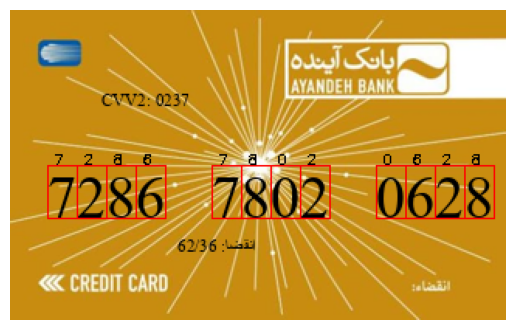

In [10]:
show_annotated_img(os.path.join(trainset_path, "images", trainset_images[1]), os.path.join(trainset_path, "annotations", trainset_annotations[1]))

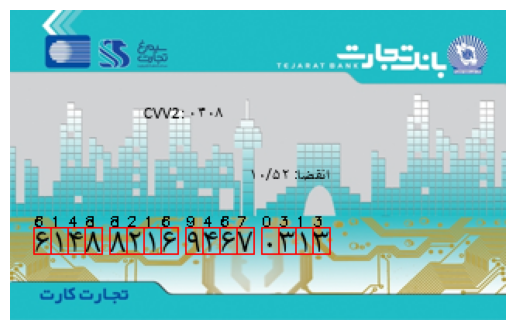

In [11]:
show_annotated_img(os.path.join(trainset_path, "images", trainset_images[50_000]), os.path.join(trainset_path, "annotations", trainset_annotations[50_000]))

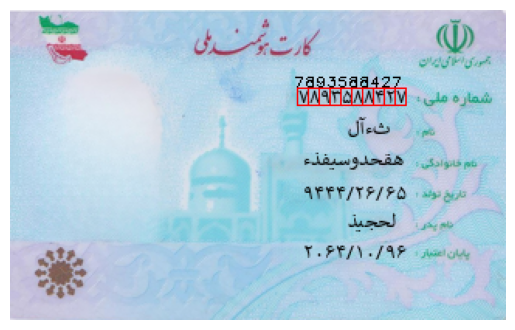

In [12]:
show_annotated_img(os.path.join(trainset_path, "images", trainset_images[90_000]), os.path.join(trainset_path, "annotations", trainset_annotations[90_000]))

## Preparing the Dataset

In [13]:
x_train, x_val, y_train, y_val = train_test_split(trainset_images, trainset_annotations, test_size=0.15, shuffle=True, random_state=42)
len(x_train), len(x_val)

(169972, 29996)

In [14]:
from ocr.data_preparation import create_annotation_lists


train_confs, train_bboxes, train_classes, train_card_types, train_cvv2s, train_exp_dates = create_annotation_lists(y_train)
val_confs, val_bboxes, val_classes, val_card_types, val_cvv2s, val_exp_dates = create_annotation_lists(y_val)

Creating a pool of 12 processes for 169972 files.
Closed the pool. Saving the results ...

Creating a pool of 12 processes for 29996 files.
Closed the pool. Saving the results ...



In [15]:
def preprocess_img_annot(img_path, confs, classes_list, bboxes, card_type, cvv2, exp_date):
    x = tf.io.read_file(trainset_path+"/images/"+img_path)
    x = tf.image.decode_image(x)

    y = {
        **{f"confs_anchor_{i}": confs[..., i, None] for i in range(num_anchors)}, 
        **{f"bboxes_anchor_{i}": bboxes[i] for i in range(len(bboxes))}, 
        **{f"classes_anchor_{i}": classes_list[i] for i in range(len(classes_list))}, 
    } | ({"card_type": card_type} if training_phase_2 else {}) | \
        ({f"cvv2_digit_{i}": cvv2[..., i] for i in range(4)} if training_phase_2 else {}) | \
        ({f"exp_date_digit_{i}": exp_date[..., i] for i in range(8)} if training_phase_2 else {})
    
    return x, y

In [16]:
trainset = tf.data.Dataset.from_tensor_slices((x_train, train_confs, train_classes, train_bboxes, train_card_types, train_cvv2s, train_exp_dates))
trainset = trainset.map(preprocess_img_annot, num_parallel_calls=tf.data.AUTOTUNE)
trainset = trainset.shuffle(1_000).batch(batch_size).prefetch(5)

valset = tf.data.Dataset.from_tensor_slices((x_val, val_confs, val_classes, val_bboxes, val_card_types, val_cvv2s, val_exp_dates))
valset = valset.map(preprocess_img_annot, num_parallel_calls=tf.data.AUTOTUNE)
valset = valset.batch(batch_size).prefetch(5)

## Creating the Model

In [17]:
from ocr.model_creation import create_sliding_window_ocr_model


model = create_sliding_window_ocr_model()

model.summary()

Model: "sliding_window_ocr_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 200, 320, 3)  0          ['image[0][0]']                  
                                                                                                  
 xception_preprocess (Lambda)   (None, 200, 320, 3)  0           ['data_augmentation[0][0]']      
                                                                                                  
 xception (Functional)          (None, 7, 10, 2048)  20861480    ['xception

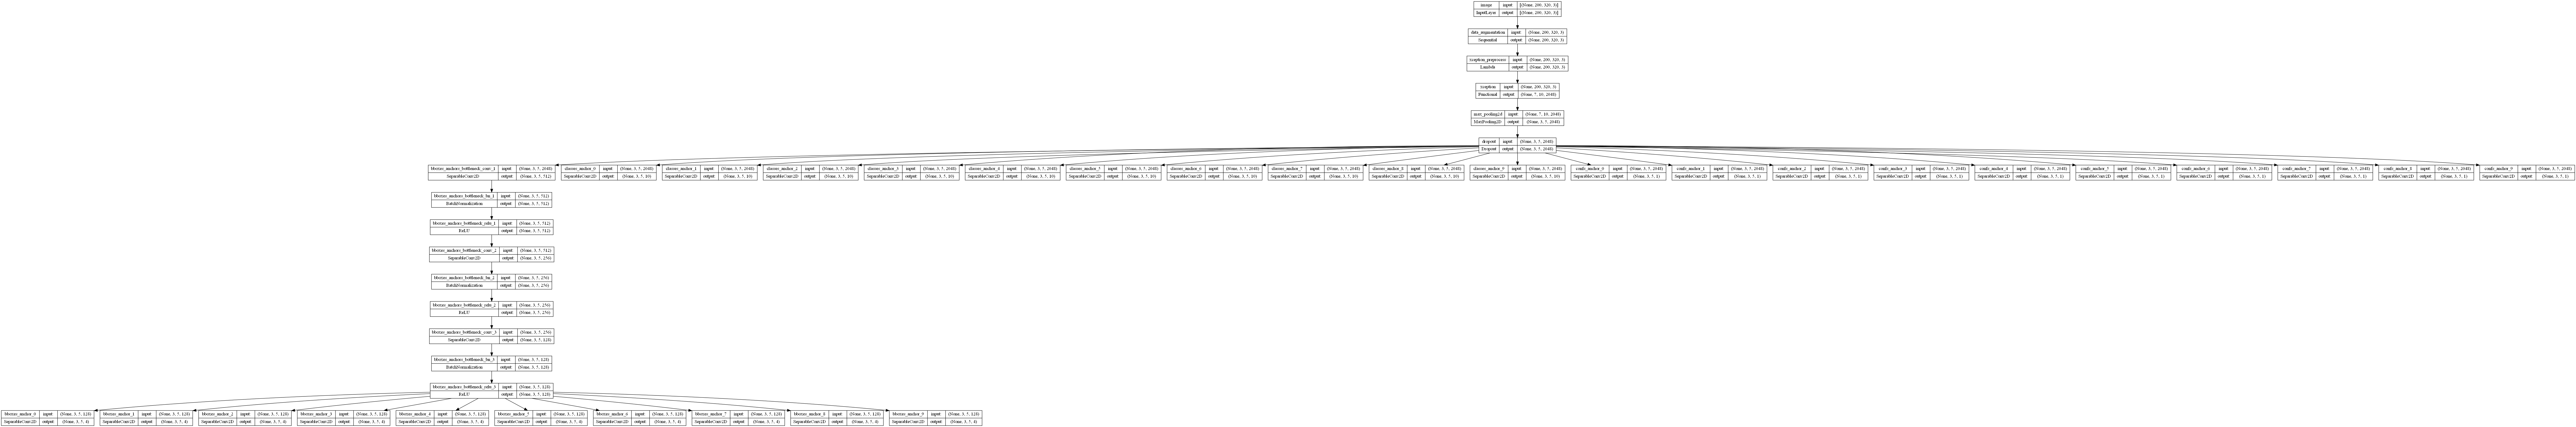

In [18]:
utils.plot_model(
    model,
    to_file=model_plot_path,
    show_shapes=True,
    show_layer_names=True,
)

## Training the Model

In [19]:
from ocr.callback_creation import get_callbacks_list


callbacks_list = get_callbacks_list()

In [20]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=valset,
    callbacks=callbacks_list,
).history

Epoch 1/100
2656/2656 [==============================] - 3787s 1s/step - loss: 23.7140 - bboxes_anchor_0_loss: 0.1031 - bboxes_anchor_1_loss: 0.0984 - bboxes_anchor_2_loss: 0.1022 - bboxes_anchor_3_loss: 0.1041 - bboxes_anchor_4_loss: 0.1065 - bboxes_anchor_5_loss: 0.1070 - bboxes_anchor_6_loss: 0.1055 - bboxes_anchor_7_loss: 0.1040 - bboxes_anchor_8_loss: 0.1034 - bboxes_anchor_9_loss: 0.0943 - classes_anchor_0_loss: 0.0037 - classes_anchor_1_loss: 0.0024 - classes_anchor_2_loss: 0.0023 - classes_anchor_3_loss: 0.0022 - classes_anchor_4_loss: 0.0024 - classes_anchor_5_loss: 0.0026 - classes_anchor_6_loss: 0.0025 - classes_anchor_7_loss: 0.0024 - classes_anchor_8_loss: 0.0025 - classes_anchor_9_loss: 0.0029 - confs_anchor_0_loss: 2.2462 - confs_anchor_1_loss: 2.2670 - confs_anchor_2_loss: 2.2680 - confs_anchor_3_loss: 2.2765 - confs_anchor_4_loss: 2.2721 - confs_anchor_5_loss: 2.2582 - confs_anchor_6_loss: 2.2631 - confs_anchor_7_loss: 2.2700 - confs_anchor_8_loss: 2.2734 - confs_ancho

## Plotting the Training Metrics

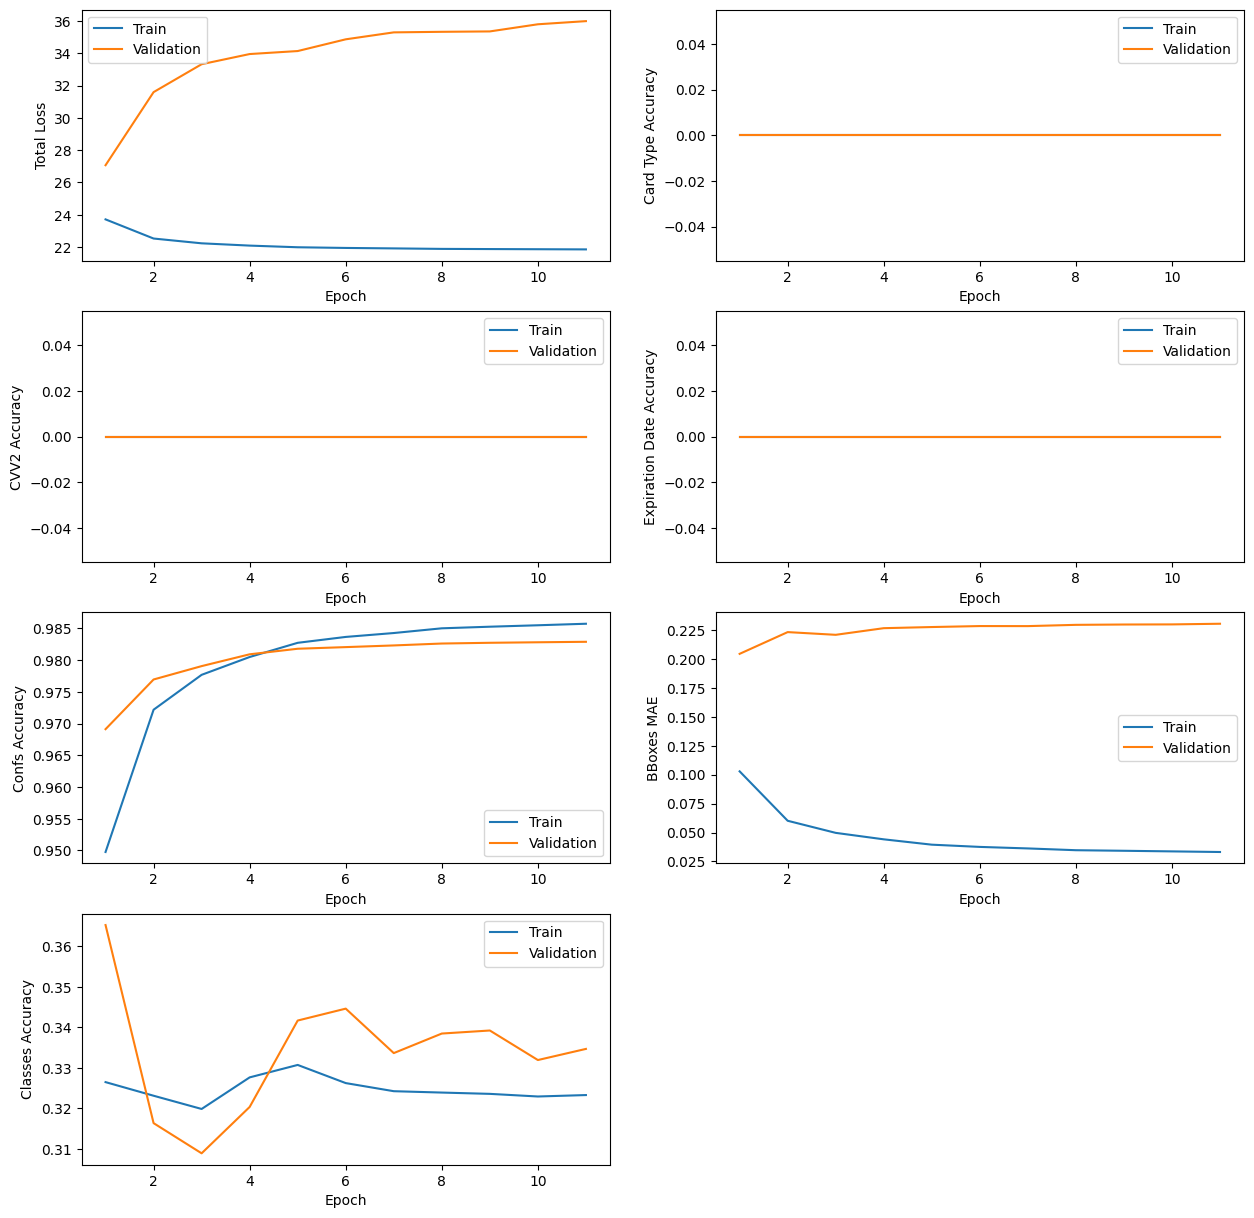

In [21]:
from ocr.history_plotting import plot_history


plot_history(history)

## Predicting by the Model

In [22]:
from ocr.model_creation import load_model
from ocr.utilities import predict_and_show


model = load_model()

1/1 [==============================] - 2s 2s/step
Confidence Scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Found Classes: [6, 4, 6, 6, 8, 6, 8, 4, 4, 2]
Found Objects #: 10

Card Type: -1
CVV2: -1
Expiration Date: -1


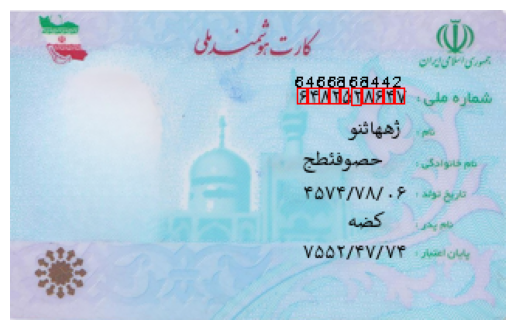

In [23]:
predict_and_show(model, "./dataset/trainset/images/"+x_train[10])

1/1 [==============================] - 0s 47ms/step
Confidence Scores: [0.84, 0.91, 0.55, 0.64, 0.62, 0.64, 0.95, 0.9, 0.74, 0.77, 0.91, 0.66, 0.85]
Found Classes: [6, 8, 8, 7, 7, 7, 9, 2, 3, 5, 1, 4, 8]
Found Objects #: 13

Card Type: -1
CVV2: -1
Expiration Date: -1


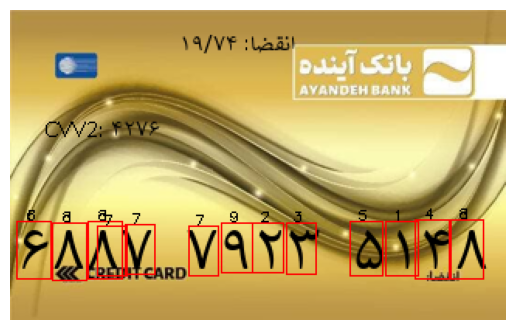

In [24]:
predict_and_show(model, "./dataset/trainset/images/"+x_train[5])

1/1 [==============================] - 0s 61ms/step
Confidence Scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Found Classes: [3, 5, 0, 5, 5, 5, 5, 5, 5, 6]
Found Objects #: 10

Card Type: -1
CVV2: -1
Expiration Date: -1


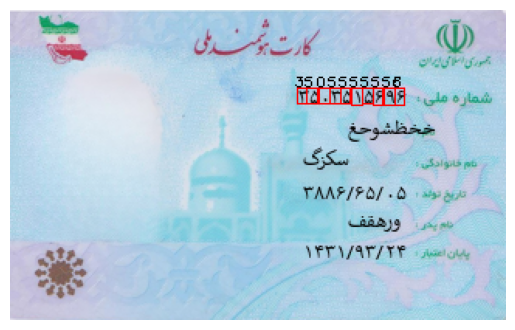

In [25]:
predict_and_show(model, "./dataset/trainset/images/"+x_val[150])

1/1 [==============================] - 0s 42ms/step
Confidence Scores: [0.95, 0.97, 0.81, 0.74, 0.8, 0.98, 0.88, 0.71, 0.99, 0.89, 0.84, 0.52, 0.65, 0.83, 0.95]
Found Classes: [7, 9, 1, 2, 2, 4, 4, 6, 3, 1, 1, 8, 9, 3, 8]
Found Objects #: 15

Card Type: -1
CVV2: -1
Expiration Date: -1


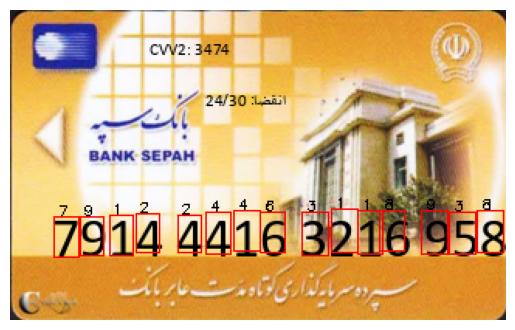

In [26]:
predict_and_show(model, "./dataset/trainset/images/"+x_val[100])